In [261]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 231 µs (started: 2023-02-28 15:46:06 -05:00)


Imports

In [262]:
import numpy as np
import matplotlib.pyplot as plt  # required for plotting

from functools import partial

from braket.ahs.atom_arrangement import AtomArrangement

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator
from braket.aws import AwsDevice 
from collections import Counter

from scipy.spatial.distance import jensenshannon
from scipy.spatial.distance import pdist

import pickle
import networkx as nx
import os


time: 450 µs (started: 2023-02-28 15:46:06 -05:00)


In [263]:
import sys
# check using the right virtual environment
sys.prefix

'/Users/yan/Repositories/qhack23_rydberg_graph/venv'

time: 929 µs (started: 2023-02-28 15:46:07 -05:00)


In [264]:
from utils import *

time: 152 µs (started: 2023-02-28 15:46:07 -05:00)


In [288]:
name_method = "aquila"

time: 152 µs (started: 2023-03-05 18:50:52 -05:00)


In [265]:
#@title Define the graph

a = 5.3e-6  # nearest-neighbor separation (in meters)

# Define coordiantes of the atoms in the graph A
# as a numpy array of shape (N, 2), where N is the number of nodes
graphA_nodes = np.array([[0., 0.],[0., 1.], [np.sqrt(3)/2, 0.5], [np.sqrt(3)/2 + 1., 0.5], 
                          [np.sqrt(3) + 1., 0.], [np.sqrt(3) + 1., 1.]])
graphB_nodes = np.array([[0., 0.],[0., 1.], [1., 0.], [1, 1], 
                          [2., 0.], [2., 1.]])                          
graphs_nodes = [graphA_nodes, graphB_nodes] 
graphs_nodes = [(np.rint(graph_nodes_float)).astype(int) for graph_nodes_float in graphs_nodes]

time: 525 µs (started: 2023-02-28 15:46:07 -05:00)


In [266]:
graphs = pickle.load(open('Datasets/PTC_graphs_max_12_nodes.p', 'rb'))
# graphs_pos = [nx.spring_layout(graph, k=1.5) for graph in graphs]
# graphs_nodes = [np.array([list(pos) for pos in graph_pos.values()]) for graph_pos in graphs_pos]
# min_dist = [np.min(pdist(graph_nodes)) for graph_nodes in graphs_nodes]
# graphs_pos = [nx.spring_layout(graph, k=1, scale=1/min_d) for min_d, graph in zip(min_dist, graphs)]
# graphs_nodes = [np.array([list(pos) for pos in graph_pos.values()]) for graph_pos in graphs_pos]

time: 2.12 ms (started: 2023-02-28 15:46:07 -05:00)


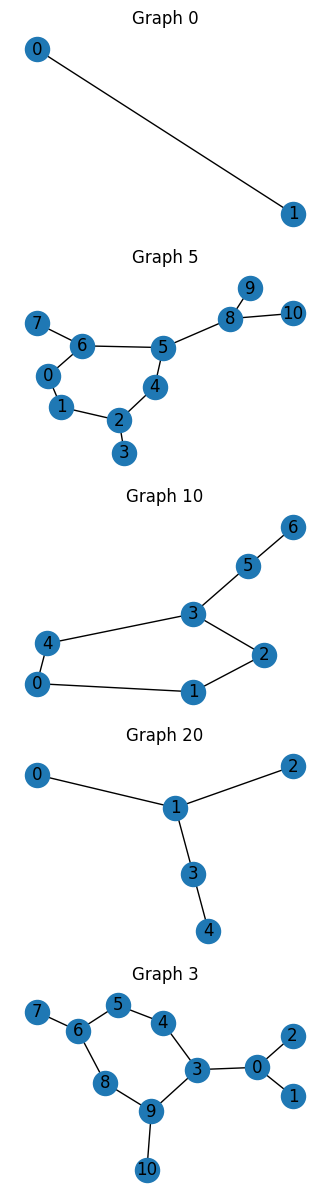

time: 225 ms (started: 2023-02-28 15:46:07 -05:00)


In [267]:
#@title Plot graphs 
idices = [0, 5, 10, 20, 3]
fig, axs = plt.subplots(len(idices), 1, figsize=(4, 3 * len(idices)))        
plot_graphs(axs, idices, graphs)        

In [268]:
def get_register(graph_nodes):
    register = AtomArrangement()
    for node in graph_nodes:
        register.add(node * a)
    return register

time: 242 µs (started: 2023-02-28 15:46:07 -05:00)


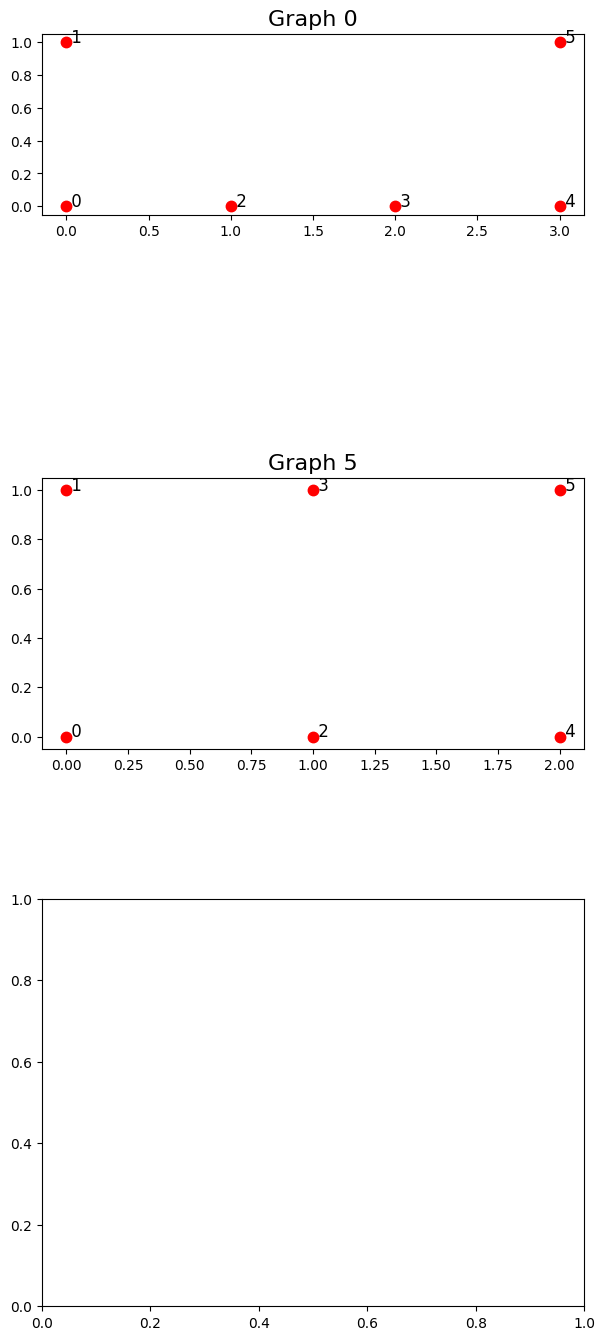

time: 200 ms (started: 2023-02-28 15:46:07 -05:00)


In [269]:
idices = [0, 5, 10, 20, 3]
labels = idices
fig, axes = plt.subplots(3, 1, figsize=(7,6 * 3))
for i, (ax, graph_nodes) in enumerate(zip(axes, graphs_nodes)):
    # register = get_register(graph_nodes)
    xs, ys = (graph_nodes[:, 0], graph_nodes[:, 1])
    ax.plot(xs, ys, 'r.', ms=15)
    for idx, (x, y) in enumerate(zip(xs, ys)):
        ax.text(x, y, f" {idx}", fontsize=12)
    ax.set_aspect('equal')    
    ax.set_title(f"Graph {labels[i]}", fontsize=16)
# plt.show()  # this will show the plot below in an ipython or jupyter session

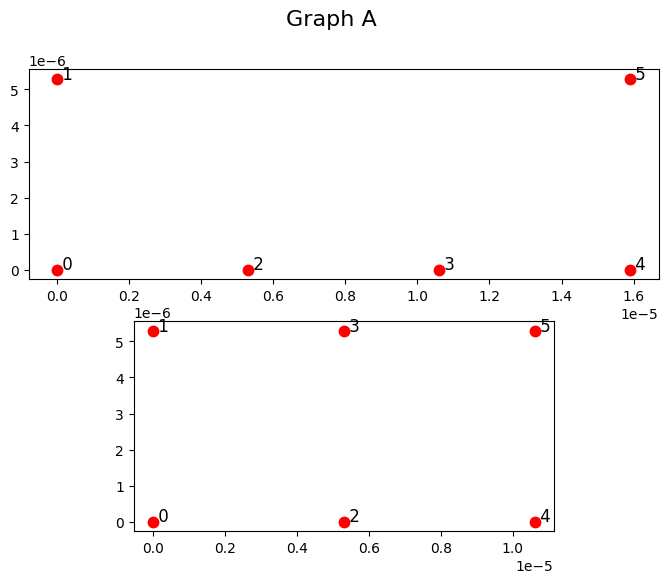

time: 117 ms (started: 2023-02-28 15:46:07 -05:00)


In [270]:
# can also use the register to plot the graph to double check

fig, axes = plt.subplots(2, 1, figsize=(10,6))
for ax, graph_nodes in zip(axes, graphs_nodes):
    register = get_register(graph_nodes)
    xs, ys = [register.coordinate_list(dim) for dim in (0, 1)]
    ax.plot(xs, ys, 'r.', ms=15)
    for idx, (x, y) in enumerate(zip(xs, ys)):
        ax.text(x, y, f" {idx}", fontsize=12)
    ax.set_aspect('equal')    
    plt.suptitle("Graph A", fontsize=16)
# plt.show()  # this will show the plot below in an ipython or jupyter session

In [271]:
#@title Define parameters of the simulation
def get_drive(time_max=4e-6):
    """AnalogHamiltonianSimulation requires a DrivingField object as input.
    This function returns a DrivingField object that represents the driving 
    used in https://arxiv.org/pdf/2211.16337.pdf

    Args:
        time_max (float): The maximum time (in seconds) of the driving field. 
        The driving field is defined for 0 <= t <= time_max.
    
    Returns:
        DrivingField: The driving field
    """
    # smooth transition from "down" to "up" state
    # time_max = 4e-6  # seconds
    time_ramp = 1e-7  # seconds
    omega_max = 1e6  # rad / sec
    # omega_max = 6300000.0  # rad / sec
    # delta_start = -5 * omega_max
    # delta_end = 5 * omega_max
    delta_start = 0.7 * omega_max
    # phi_start = 0.06 * omega_max
    phi_start = 0.
    delta_end = 0.7 * omega_max

    C6 = 5.42 * 1e-24 # C6 coefficient (in rad m^6 / s)
    # check Rydberg effective blockade radius
    R_6 = (C6 / np.sqrt(omega_max**2 + delta_start**2))**(1/6) # in meters
    # print(f"R_6 = {R_6 * 1e6} um and is equivalent to {R_6 / a} lattice spacings")
    # print(f"time could be {np.pi / (np.sqrt(2) * omega_max)}")

    time_end_ramp = np.round(time_max - time_ramp, 10)
    omega = TimeSeries()
    omega.put(0.0, 0.0)
    omega.put(time_ramp, omega_max)
    omega.put(time_end_ramp, omega_max)
    omega.put(time_max, 0.0)
    # omega.put(0.0, omega_max)
    # omega.put(time_max, omega_max)    
    # omega.put(0.0, 0.0)
    # omega.put(time_ramp, omega_max)
    # omega.put(time_max - time_ramp, omega_max)
    # omega.put(time_max, 0.0)
    # omega.put(omega_max, omega_max)

    delta = TimeSeries()
    delta.put(0.0, 0.)
    delta.put(time_ramp, delta_start)
    delta.put(time_end_ramp, delta_end)
    delta.put(time_max, 0.)
    # delta.put(delta_start, delta_end)

    phi = TimeSeries().put(0.0, phi_start).put(time_max, phi_start)

    drive = DrivingField(
        amplitude=omega,
        phase=phi,
        detuning=delta
    )
    return drive 

time: 796 µs (started: 2023-02-28 15:46:07 -05:00)


In [272]:
drive = get_drive()

time: 229 µs (started: 2023-02-28 15:46:08 -05:00)


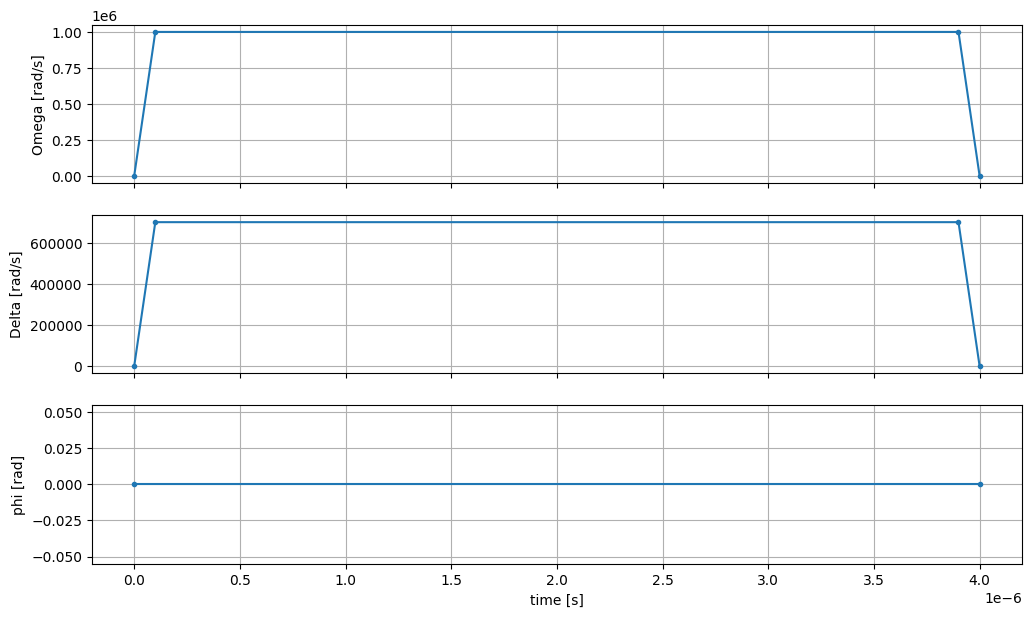

time: 160 ms (started: 2023-02-28 15:46:08 -05:00)


In [273]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

ax = axes[0]
time_series = drive.amplitude.time_series
ax.plot(time_series.times(), time_series.values(), '.-');
ax.grid()
ax.set_ylabel('Omega [rad/s]')

ax = axes[1]
time_series = drive.detuning.time_series
ax.plot(time_series.times(), time_series.values(), '.-');
ax.grid()
ax.set_ylabel('Delta [rad/s]')

ax = axes[2]
time_series = drive.phase.time_series
# Note: time series of phase is understood as a piecewise constant function
ax.step(time_series.times(), time_series.values(), '.-', where='post');
ax.set_ylabel('phi [rad]')
ax.grid()
ax.set_xlabel('time [s]')

plt.show()  # this will show the plot below in an ipython or jupyter session


In [274]:

def run_simulation(device, register, drive, shots):
    """Run the simulation on the given device and return the results.
    
    Args:
        device (Device): The device to run the simulation on
        register (AtomArrangement): The register to run the simulation on
        drive (DrivingField): The driving field to use in the simulation
        shots (int): The number of shots to run the simulation for
    
    Returns:
        Counter: The results of the simulation
    """
    ahs_program = AnalogHamiltonianSimulation(
        register=register,
        hamiltonian=drive
    )
    result_simulator = device.run(ahs_program, shots=shots).result()
    return result_simulator



def get_counts(result):
    """Aggregate state counts from AHS shot results

    A count of strings (of length = # of spins) are returned, where
    each character denotes the state of a spin (site):
       e: empty site
       u: up state spin
       d: down state spin

    Args:
       result (braket.tasks.analog_hamiltonian_simulation_quantum_task_result.AnalogHamiltonianSimulationQuantumTaskResult)

    Returns
        dict: number of times each state configuration is measured

    """
    state_counts = Counter()
    states = ['e', '1', '0']
    for shot in result.measurements:
        pre = shot.pre_sequence
        post = shot.post_sequence
        state_idx = np.array(pre) * (1 + np.array(post))
        state = "".join(map(lambda s_idx: states[s_idx], state_idx))
        state_counts.update((state,))
    return dict(state_counts)


     

time: 649 µs (started: 2023-02-28 15:46:08 -05:00)


In [275]:
from pprint import pprint as pp
shots = 50
# device = LocalSimulator("braket_ahs")
device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
device = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")
capabilities = device.properties.paradigm
pp(capabilities.dict())

{'braketSchemaHeader': {'name': 'braket.device_schema.quera.quera_ahs_paradigm_properties',
                        'version': '1'},
 'lattice': {'area': {'height': Decimal('0.000076'),
                      'width': Decimal('0.000075')},
             'geometry': {'numberSitesMax': 256,
                          'positionResolution': Decimal('1E-7'),
                          'spacingRadialMin': Decimal('0.000004'),
                          'spacingVerticalMin': Decimal('0.000004')}},
 'performance': {'lattice': {'positionErrorAbs': Decimal('1E-7')},
                 'rydberg': {'rydbergGlobal': {'rabiFrequencyErrorRel': Decimal('0.02')}}},
 'qubitCount': 256,
 'rydberg': {'c6Coefficient': Decimal('5.42E-24'),
             'rydbergGlobal': {'detuningRange': (Decimal('-125000000.0'),
                                                 Decimal('125000000.0')),
                               'detuningResolution': Decimal('0.2'),
                               'detuningSlewRateMax': Decimal(

In [276]:
t_range = np.linspace(0., 2.25*1e-6, 10)
print(f"old t is {t_range}")
t_range = np.round(t_range, 10)
print(f"new t is {t_range}")

old t is [0.00e+00 2.50e-07 5.00e-07 7.50e-07 1.00e-06 1.25e-06 1.50e-06 1.75e-06
 2.00e-06 2.25e-06]
new t is [0.00e+00 2.50e-07 5.00e-07 7.50e-07 1.00e-06 1.25e-06 1.50e-06 1.75e-06
 2.00e-06 2.25e-06]
time: 526 µs (started: 2023-02-28 15:46:09 -05:00)


In [277]:

# t_range = np.linspace(0., 4.*1e-6, 9)[1:]
t_range = np.linspace(0., 2.5*1e-6, 11)[1:]
print(f"old t is {t_range}")
t_range = np.round(t_range, 10)
# t_range = [2.5e-6]
print(f"new t is {t_range}")
my_nodesB = [0]
n_prob_list = []
n_expectationB_list = []
n_expectationC_list = []

results = []
# run simulation for different drive durations
for t_max in t_range:
    print(f"Running simulation for t_max = {t_max}")
    results_graphs = []
    for i, graph in enumerate(graphs_nodes):
        print(f"running simulation for graph {i}")
        register = get_register(graph) # get register with different graph
        drive = get_drive(t_max) # get drive with different duration
        result_simulator = run_simulation(device, register, drive, shots) # run simulation
        results_graphs.append(result_simulator)
    results.append(results_graphs)

old t is [2.50e-07 5.00e-07 7.50e-07 1.00e-06 1.25e-06 1.50e-06 1.75e-06 2.00e-06
 2.25e-06 2.50e-06]
new t is [2.50e-07 5.00e-07 7.50e-07 1.00e-06 1.25e-06 1.50e-06 1.75e-06 2.00e-06
 2.25e-06 2.50e-06]
Running simulation for t_max = 2.5e-07
running simulation for graph 0
running simulation for graph 1
Running simulation for t_max = 5e-07
running simulation for graph 0
running simulation for graph 1
Running simulation for t_max = 7.5e-07
running simulation for graph 0
running simulation for graph 1
Running simulation for t_max = 1e-06
running simulation for graph 0
running simulation for graph 1
Running simulation for t_max = 1.25e-06
running simulation for graph 0
running simulation for graph 1
Running simulation for t_max = 1.5e-06
running simulation for graph 0
running simulation for graph 1
Running simulation for t_max = 1.75e-06
running simulation for graph 0
running simulation for graph 1
Running simulation for t_max = 2e-06
running simulation for graph 0
running simulation for 

In [278]:
filename = 'results_aws_6k_100t_12nodes_all.p'
with open("results_QEK/"+filename, 'wb') as f:
    f.write(pickle.dumps(results))

# pickle.dump(results, open(filename, 'wb'))

time: 5.2 ms (started: 2023-03-01 11:37:36 -05:00)


In [286]:
len(results)

10

time: 946 µs (started: 2023-03-05 18:46:48 -05:00)


In [279]:
# new_results = pickle.load(open("results_QEK/"+filename, 'rb'))
# counts_graph = [get_counts(result_graph) for result_graph in results[0]] # get state counts from simulator result
# print(counts_graph[0])

time: 154 µs (started: 2023-03-01 11:37:36 -05:00)


In [280]:
len(results)

10

time: 810 µs (started: 2023-03-01 11:37:36 -05:00)


In [281]:
t_range = t_range[:len(results)]
t_range

array([2.50e-07, 5.00e-07, 7.50e-07, 1.00e-06, 1.25e-06, 1.50e-06,
       1.75e-06, 2.00e-06, 2.25e-06, 2.50e-06])

time: 1.03 ms (started: 2023-03-01 11:37:36 -05:00)


In [282]:

kernel_counts_fn = partial(outcome_counts, shots=shots)
kernels = []
for t_max, results_graph in zip(t_range, results): # loop over different drive durations
    counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    # counts_graph = [get_counts(result) for result in results] # get state counts from simulator result
    kernel_t = compute_kernel(counts_graph, kernel_counts_fn) # compute kernel matrix
    kernels.append(kernel_t)
kernels = np.stack(kernels)

time: 4.77 ms (started: 2023-03-01 11:37:36 -05:00)


In [289]:
filename = f'kernel_{name_method}_qubit_{12}.p'

if not os.path.isdir('results_QEK/kernels/'):
    os.mkdir('results_QEK/kernels/')
with open("results_QEK/kernels/"+filename, 'wb') as f:
    f.write(pickle.dumps(kernels))


time: 910 µs (started: 2023-03-05 18:51:08 -05:00)


Text(0, 0.5, 'kernel FS')

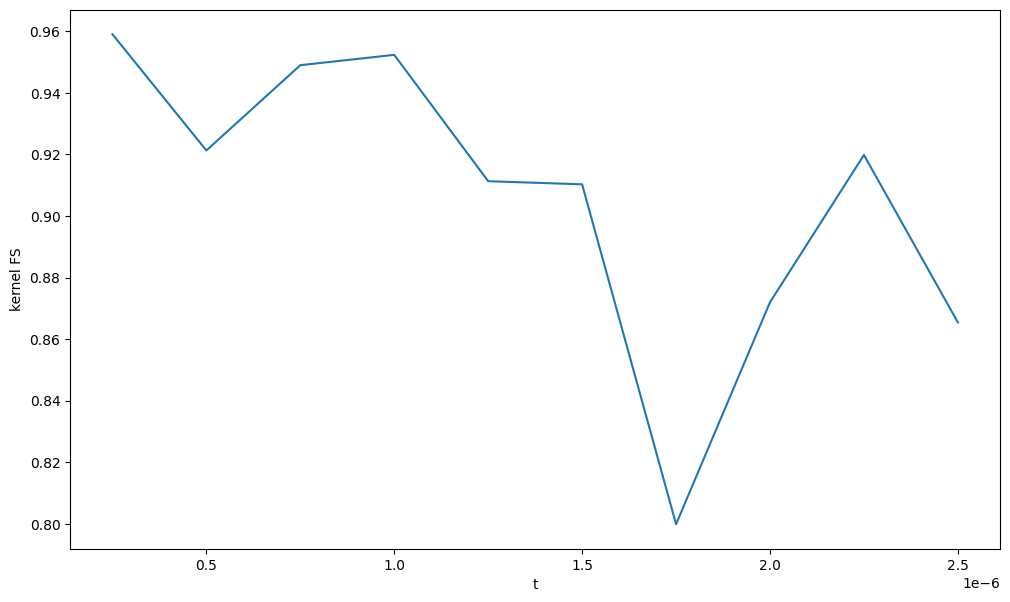

time: 89.6 ms (started: 2023-03-01 11:37:36 -05:00)


In [283]:
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(t_range, kernels[:, 0, 1], label='kernel')
axes.set_xlabel('t')
axes.set_ylabel('kernel FS')

Text(0, 0.5, 'Jensen-Shannon divergence $JS(P1, P2)$')

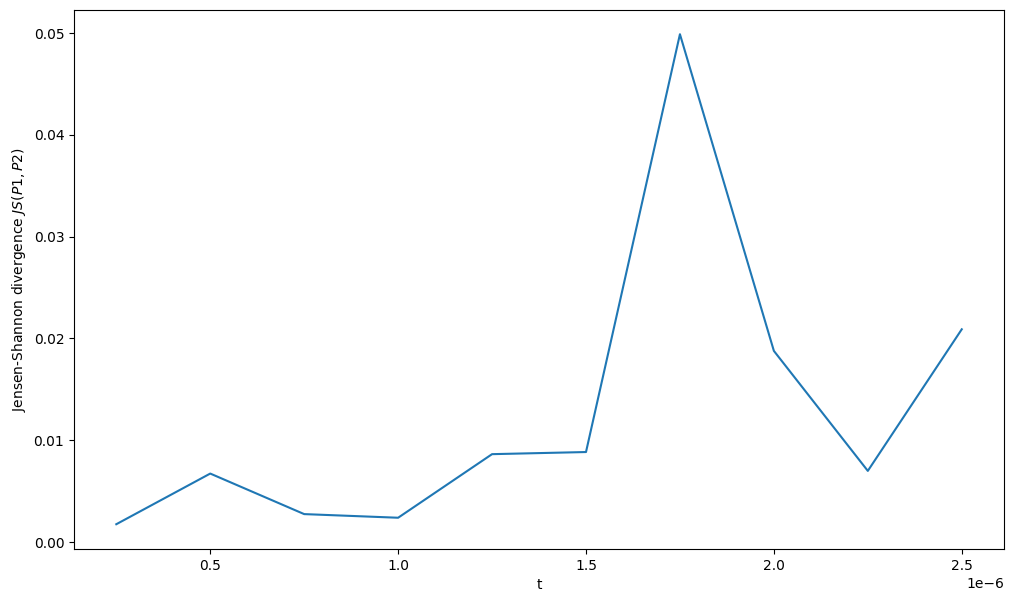

time: 91.5 ms (started: 2023-03-01 11:37:36 -05:00)


In [284]:
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(t_range, (- np.log(kernels[:, 0, 1]))**2, label='kernel')
axes.set_xlabel('t')
axes.set_ylabel(r'Jensen-Shannon divergence $JS(P1, P2)$')

In [ ]:
outcome_fn = partial(get_expectations_nodes, shots=shots, averaged_nodes=my_nodesB)
outcomes = []
for t_max, results_graph in zip(t_range, results): # loop over different drive durations
    counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    outcomes_t = compute_outcomes(counts_graph, outcome_fn) # compute kernel matrix
    # print(outcomes_t.shape)
    outcomes.append(outcomes_t)
outcomes = np.stack(outcomes)    

Text(0.5, 0, 'Drive duration [s]')

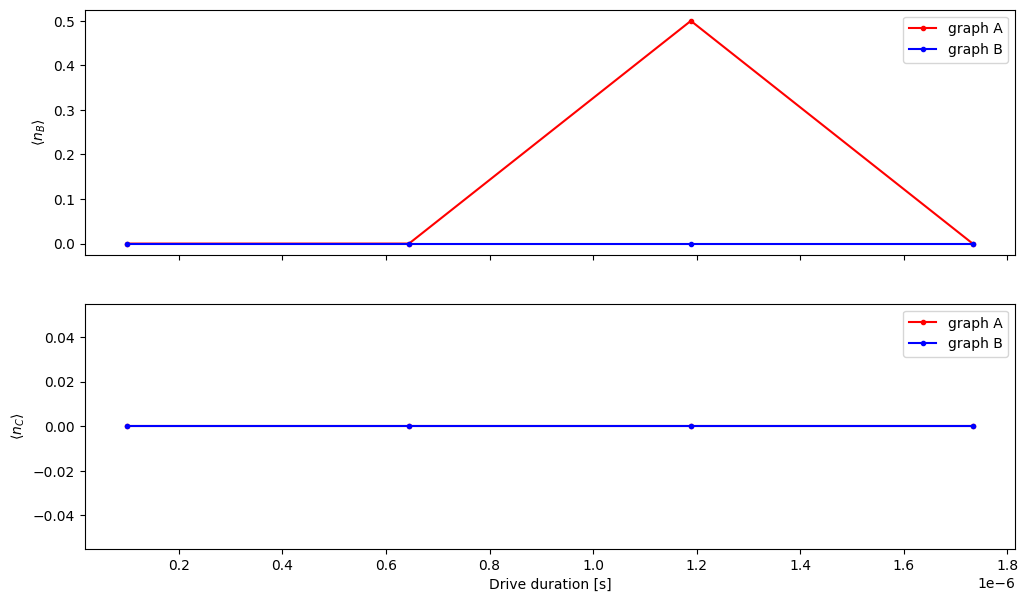

time: 165 ms (started: 2023-02-28 14:46:34 -05:00)


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
y_labels = [r'$\langle n_B \rangle$', r'$\langle n_C \rangle$']
labels = ['B', 'C']
colors = ['r', 'b']
labels_graph = ['A', 'B']
for i, ylabel in enumerate(y_labels):
    ax = axes[i]
    for j in range(2):
        ax.plot(t_range, outcomes[:, j, i], '.-', label=f"graph {labels_graph[j]}", color=colors[j])
    ax.set_ylabel(ylabel)
    ax.legend()

plt.xlabel('Drive duration [s]')
# plt.legend()
# plt.ylabel(r'$\langle n \rangle$')

In [ ]:
t_range[39]

2.03030303030303e-06

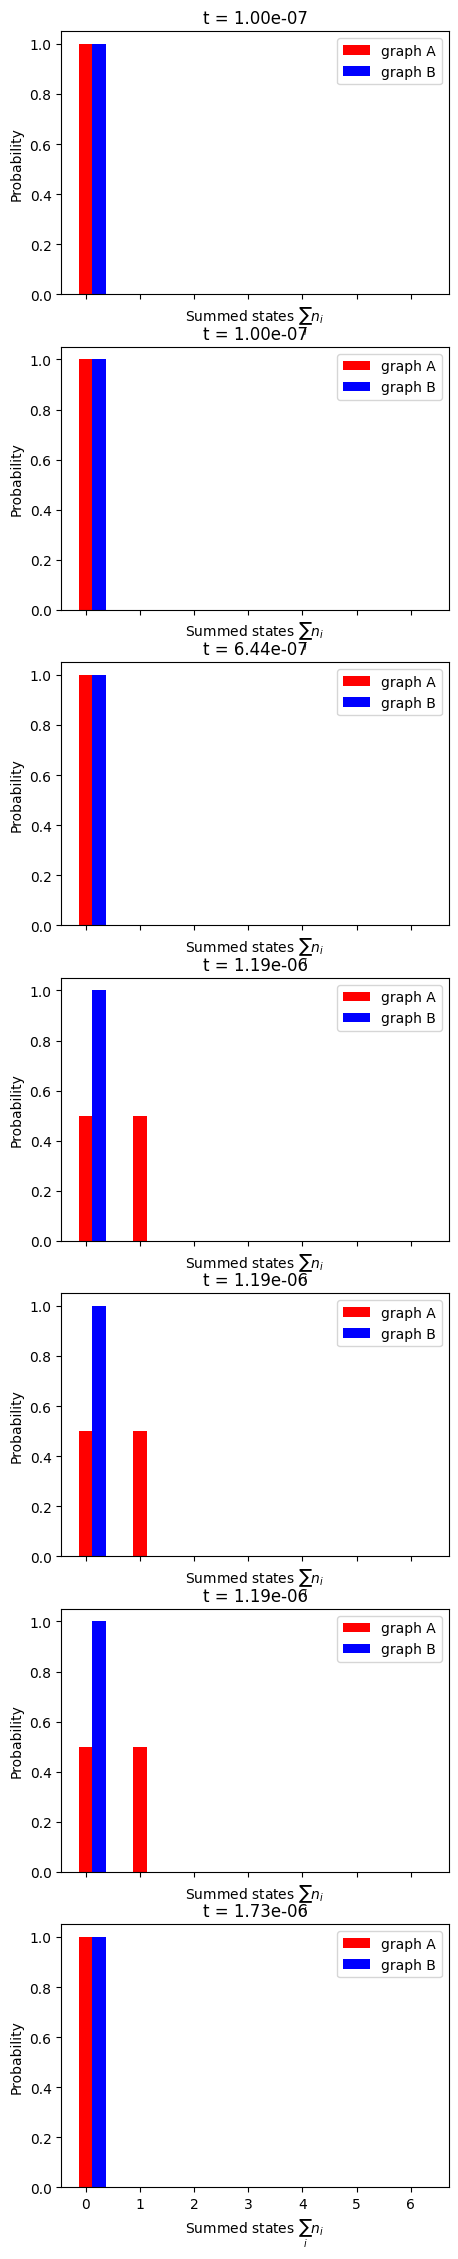

time: 564 ms (started: 2023-02-28 14:46:53 -05:00)


In [ ]:
t_list = [0.1e-6, 0.25e-6, 0.57e-6, 0.924e-6, 1.04e-6, 1.2e-6, 1.9e-6]
barWidth = 0.25
br1 = np.arange(len(graphA_nodes)+1)
br2 = [x + barWidth for x in br1]
bars = [br1, br2]
colors = ['r', 'b']
labels = ['graph A', 'graph B']
# plot the probability distribution for different drive durations as a function of summed states
fig, axes = plt.subplots(len(t_list), 1, figsize=(5, 4 * len(t_list)), sharex=True)
for t, ax in zip(t_list, axes):
    # idx = np.where(t_range == t)[0][0] # get index of t
    idx = np.argmin(np.abs(t_range - t))
    probabilities = []
    
    for i in range(2):
        counts_graph = get_counts(results[idx][i]) 
        p = get_counts_summed_probabilities(counts_graph, shots=shots)
        probabilities.append(p)
        # print(p)

        ax.bar(bars[i], p, label=labels[i], width=barWidth, color=colors[i])
        # ax.set_ylim(0, 1)
        ax.set_ylabel("Probability")
        ax.set_xlabel(r"Summed states $\sum_i n_i$")
        ax.legend()
        ax.set_title('t = {:.2e}'.format(t_range[idx]))
    # ax.set_title('t = {:.2e}'.format(t))




#### look at correlation function

In [ ]:
counts_simulator = get_counts(result_simulator)  # takes about 5 seconds
print(counts_simulator)

{'000000': 652, '000001': 333, '000010': 336, '000100': 179, '000101': 1, '000110': 2, '001000': 167, '001001': 1, '010000': 360, '010001': 1204, '010010': 585, '011000': 1, '100000': 350, '100001': 554, '100010': 1271, '100100': 4}


In [ ]:
def get_density_correlation_Z2(result):
    post_sequences = np.array([list(measurement.post_sequence) for measurement in result.measurements])
    return np.cov(post_sequences.T)

gij = get_density_correlation_Z2(result_simulator)

We see a disjoint deparation in this graph!

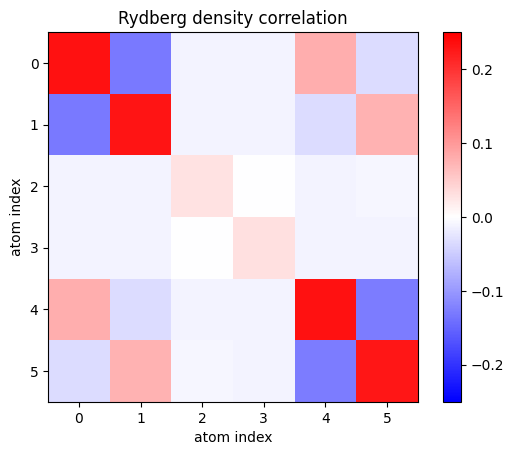

In [ ]:
plt.imshow(gij, cmap='bwr', vmin=-0.25, vmax=+0.25)
plt.xticks(range(len(graphA_nodes)), [f'{i}' for i in range(len(graphA_nodes))])
plt.xlabel("atom index")
plt.yticks(range(len(graphA_nodes)), [f'{j}' for j in range(len(graphA_nodes))])
plt.ylabel("atom index")
plt.title('Rydberg density correlation')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()